# Example Burgers' equation

$\partial_t u=-u u_x+v u_{x x}$

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation with sine initial conditions.

We start by importing the required libraries and setting the plotting style:

In [1]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic
from scipy.io import loadmat

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
# device = "xpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cpu


# Dataset
Create all the argument we need to create a Burgers dataset:

In [2]:
# Making dataset
def load_data():
    data = loadmat("../HwaQuantum/result/DEPOLARIZING0_lambda2_offset2_dt0.15_nqubits9.mat")
    time = np.ravel(data["t"]).squeeze()
    x = np.ravel(data["x"]).squeeze()
    array = {}
    array["x"], array["t"] = np.meshgrid(x, time, indexing="ij")
    array["u"] = data["u"]
    array["x"].shape, array["t"].shape, array["u"].shape
    coords = torch.from_numpy(np.stack((array["t"], array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

In [3]:
preprocess_kwargs = {"noise_level": 0.0}
dataset = Dataset(
    load_data,
    preprocess_kwargs=preprocess_kwargs,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 3000},
    device=device,
)

Preprocessing data
Dataset is using device:  cpu


Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

Let's plot it to get an idea of the data. As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. We also added 5% of noise.

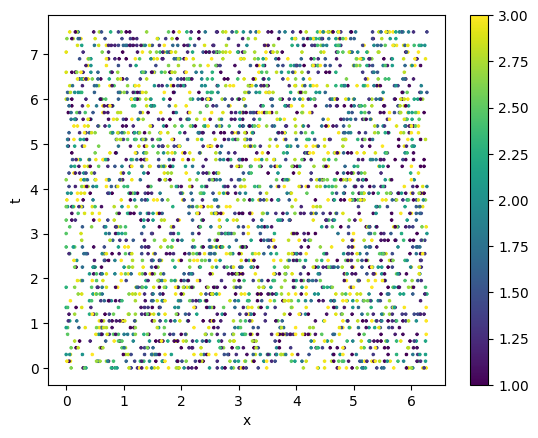

In [4]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:, 1], coords[:, 0], c=data[:, 0], marker="x", s=3)
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.colorbar(mappable=im)

plt.show()

We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [5]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [6]:
network = NN(2, [50, 50, 50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 2 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [7]:
library = Library1D(poly_order=2, diff_order=3)

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [8]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator 

In [9]:
constraint = LeastSquares()
# Configuration of the sparsity scheduler

Now we instantiate the model and send it to the GPU and select the optimizer 

In [10]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.9, 0.999), amsgrad=True, lr=1e-3
)

## Run DeepMoD 

We can now run DeepMoD using all the options we have set, the training and test loaders:
* The directory where the tensorboard file is written (log_dir)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [11]:
%%time
foldername = "./data/deepymod/TestOnDpol/"
torch.set_num_threads(18)
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    exp_ID="Test",
    write_iterations=25,
    max_iterations=100000,
    delta=1e-4,
    patience=200,
)

 99975  MSE: 4.81e-01  Reg: 5.09e-03  L1: 1.96e+01 Algorithm converged. Writing model to disk.
CPU times: total: 4h 48min 48s
Wall time: 54min 15s


IndexError: list index out of range

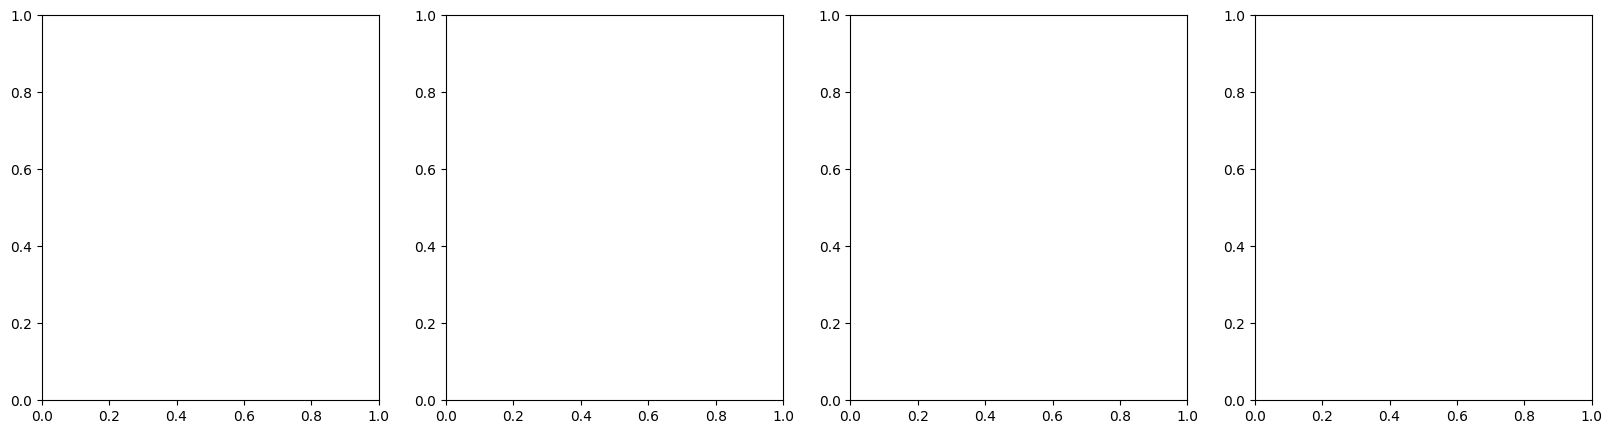

In [12]:
from deepymod.analysis import load_tensorboard

history = load_tensorboard(foldername)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":
        if history_key_parts[-1] == "0":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="--",
            )
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle=":",
            )
        else:
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="-",
            )
        if history_key_parts[0] == "remaining":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="-.",
            )
    if history_key_parts[0] == "coeffs":
        if history_key_parts[2] == "0":
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="--",
            )
        elif history_key_parts[2] == "1":
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle=":",
            )
        else:
            axs[1].plot(
                history[history_key],
                label=history_key_parts[2]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="-",
            )
    if history_key_parts[0] == "unscaled":
        if history_key_parts[3] == "0":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )
    if history_key_parts[0] == "estimator":
        if history_key_parts[3] == "0":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )

# axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-2, 2])
axs[2].set_ylim([-2, 2])
axs[3].set_ylim([-2, 2])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()

The physical coefficients

In [13]:
model.constraint_coeffs()

[tensor([[ 0.0000e+00],
         [-9.8686e-01],
         [ 2.9104e-01],
         [ 6.6185e-04],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [-2.1510e-01],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 1.4881e-01],
         [ 3.3055e-02],
         [ 0.0000e+00]], grad_fn=<MaskedScatterBackward0>)]

Sparsity masks provide the active and non-active terms in the PDE:

estimatior_coeffs gives the magnitude of the active terms:

In [14]:
model.estimator_coeffs()

[array([[ 0.        ],
        [-1.2319332 ],
        [ 1.7121911 ],
        [ 0.44902313],
        [ 0.        ],
        [ 0.        ],
        [-0.3891019 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.80537367],
        [-1.4416935 ],
        [ 0.        ]], dtype=float32)]